In [3]:
import pandas as pd
import numpy as np

from pylab import rcParams

import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

In [4]:
train = pd.read_csv('extracted_fields_train.gz', 
                    dtype={'date': str, 'fullVisitorId': str, 'sessionId':str}, nrows=None)

**Визуализация распределений категорий признаков посещений пользователей интернет-магазина Google Merchandise Store.**

 - Каждый stacked bar chart показывает в каком соотношении находятся категории данного признака. 
 - Автоматически выберутся те признаки, где есть хотя бы одна категория с долей от 5 до 99,9%.
 - Данное решение подойдёт для любого датасета.

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


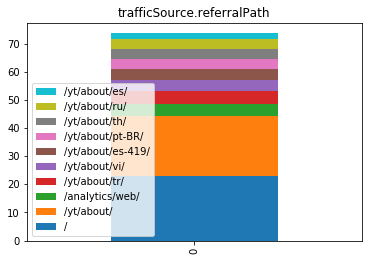

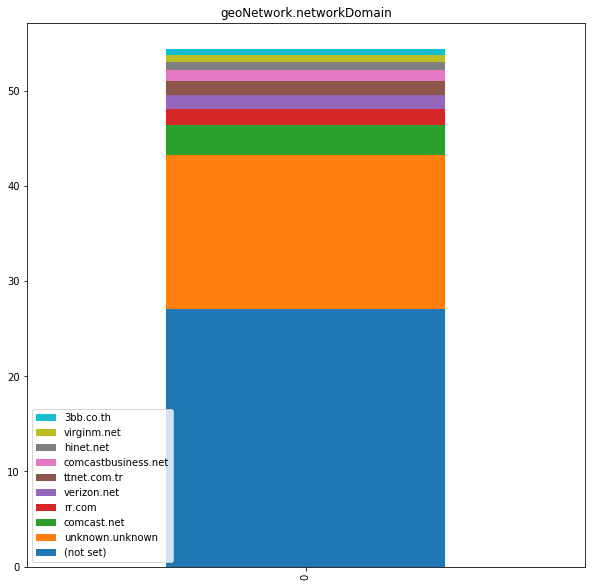

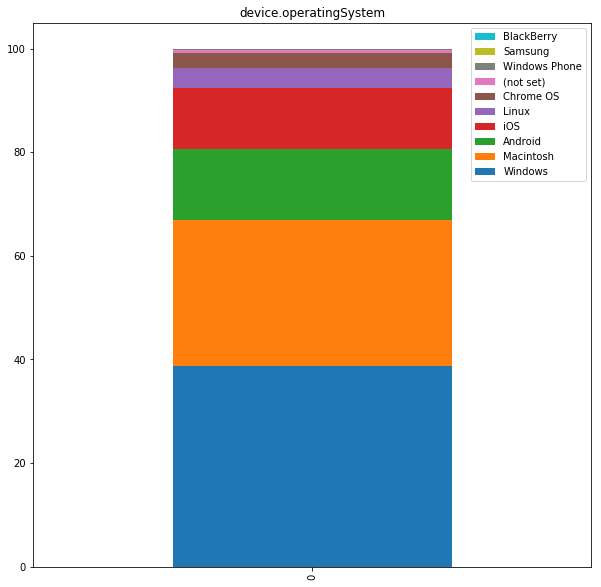

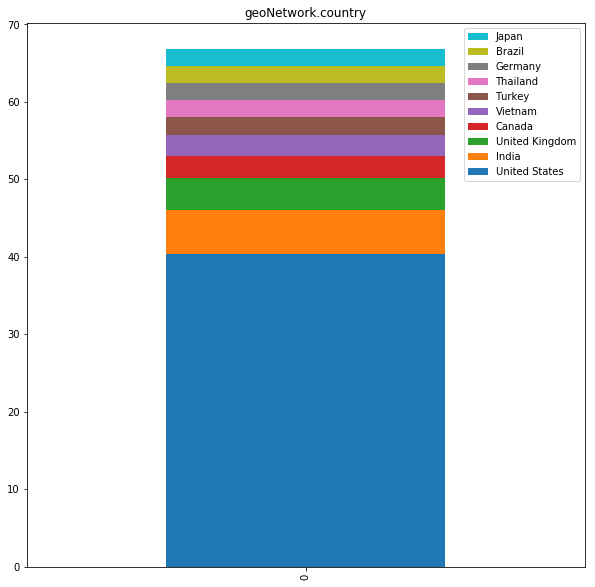

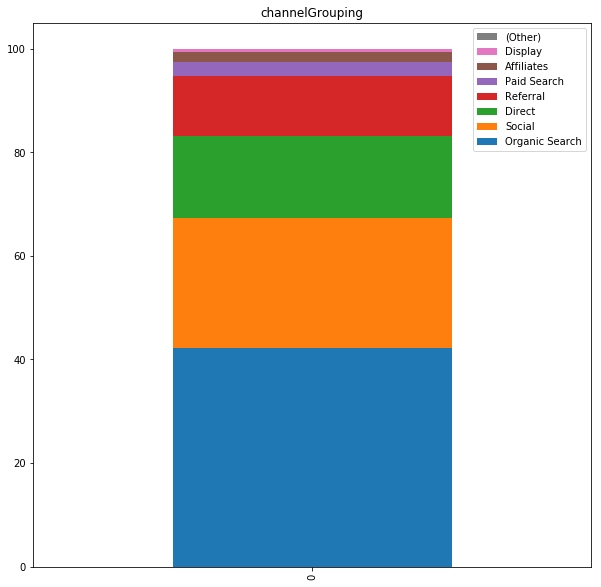

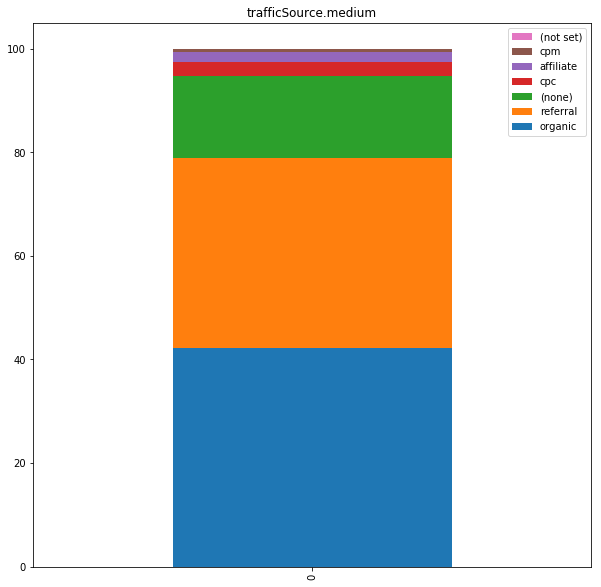

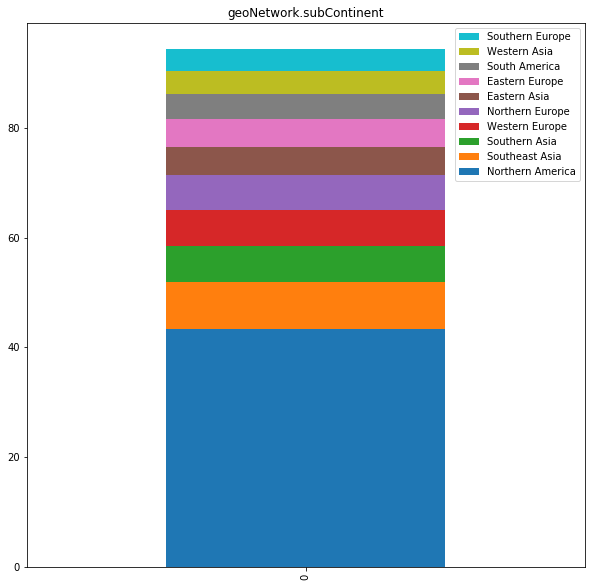

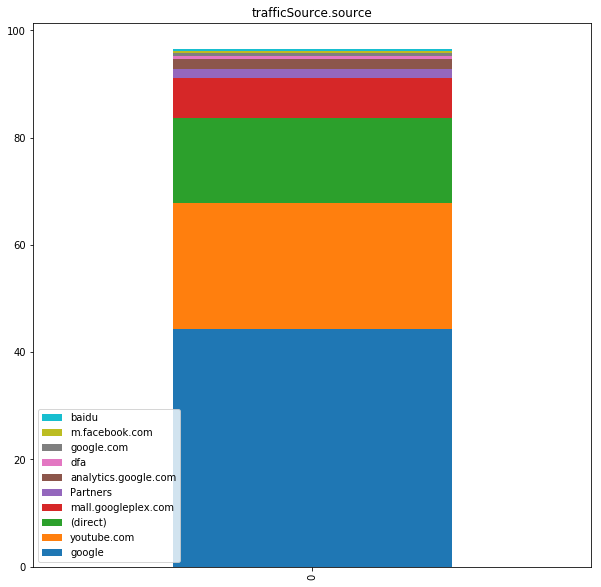

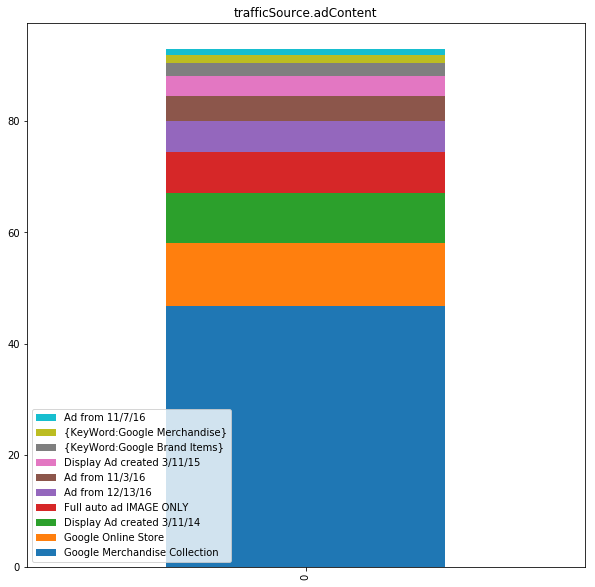

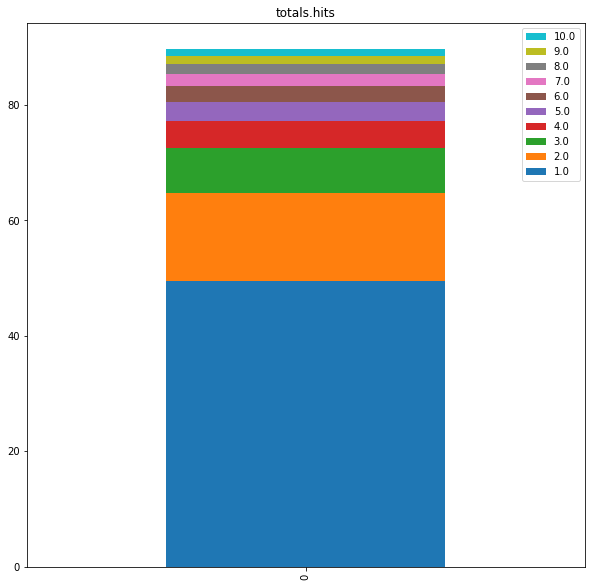

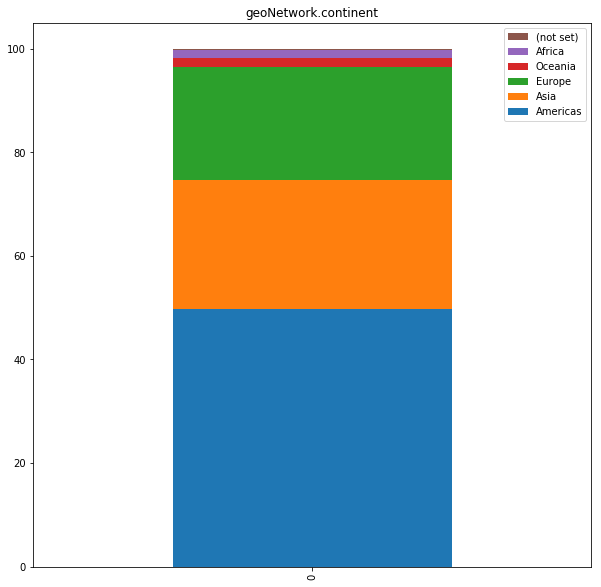

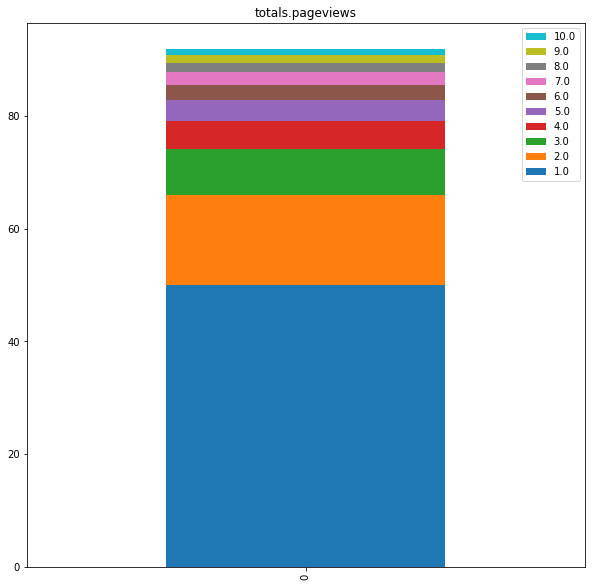

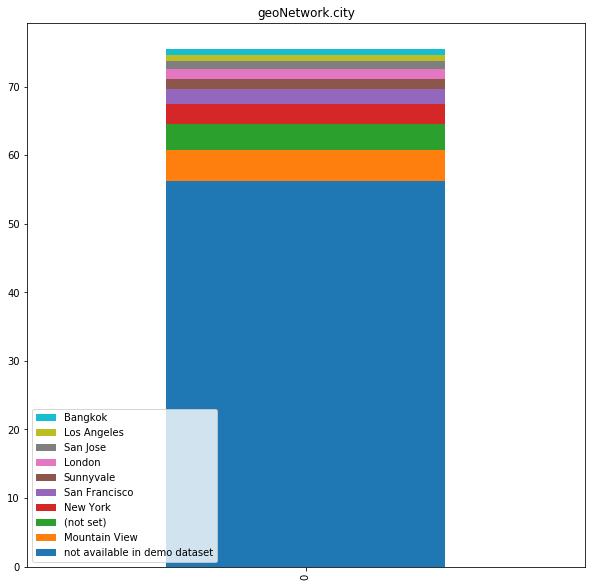

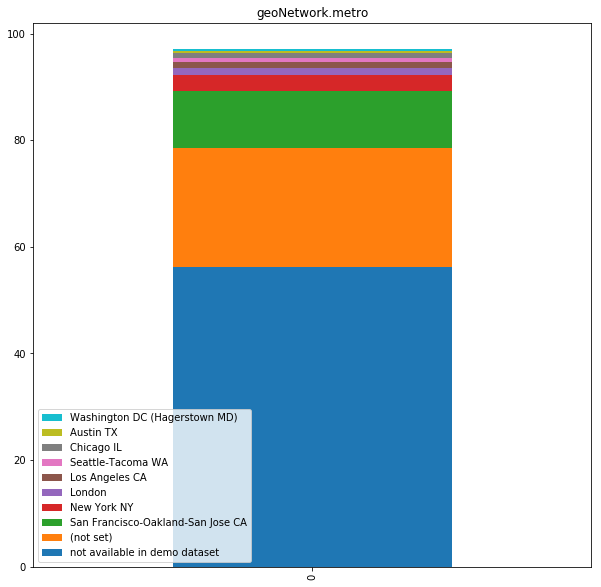

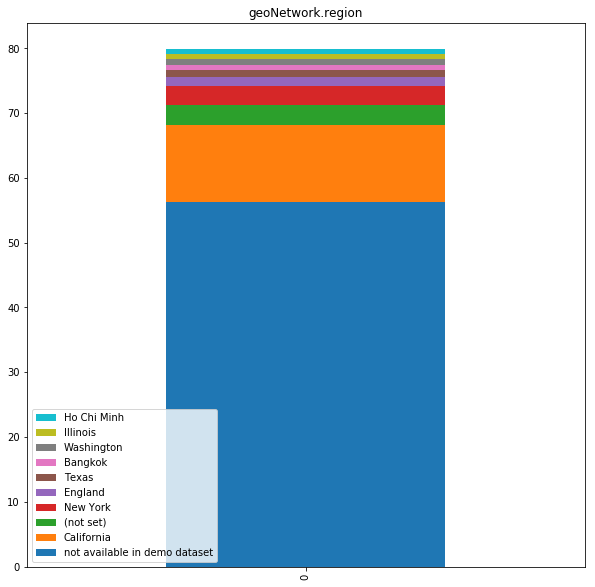

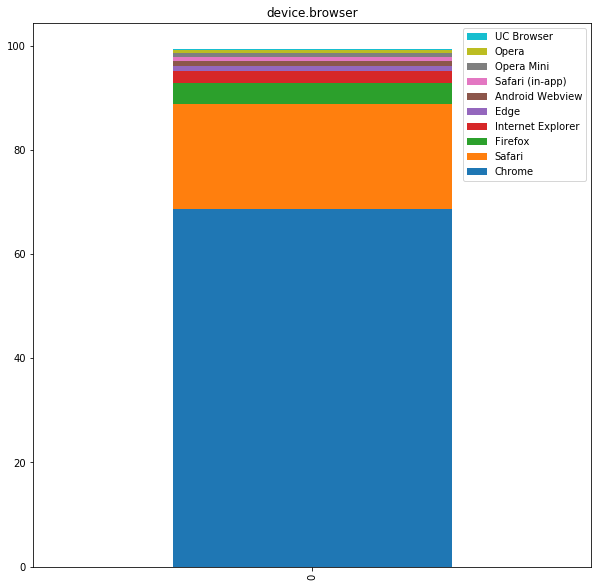

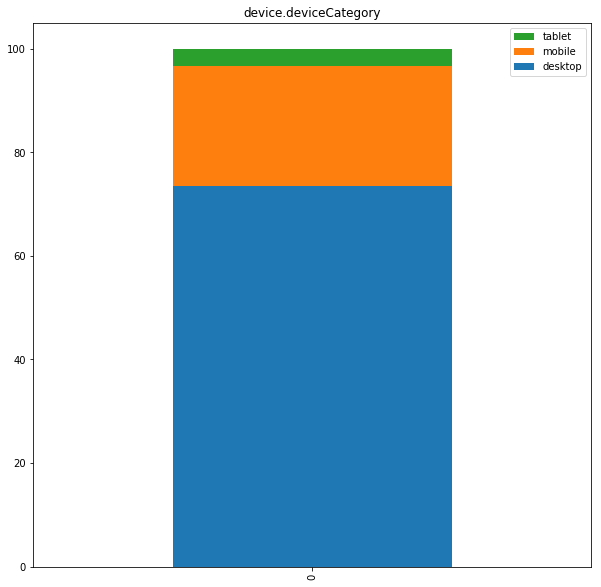

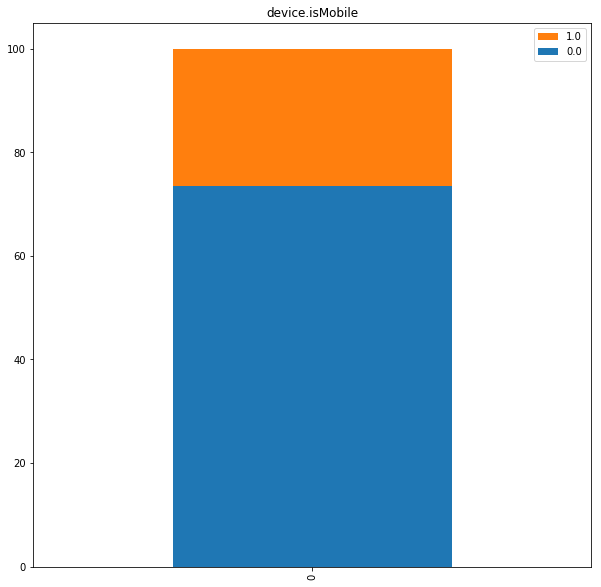

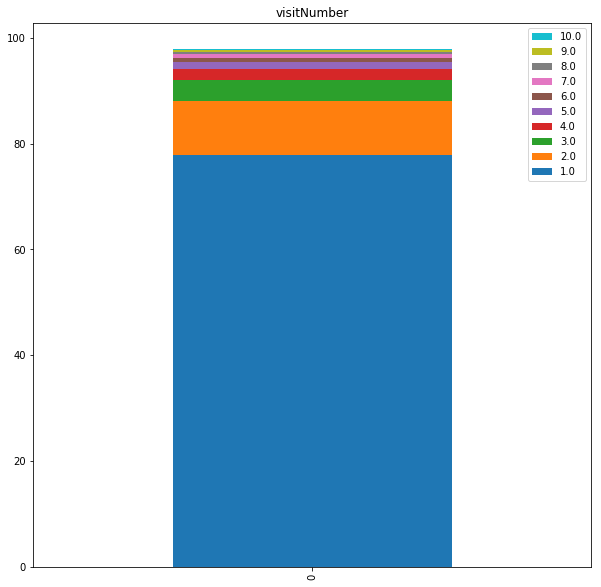

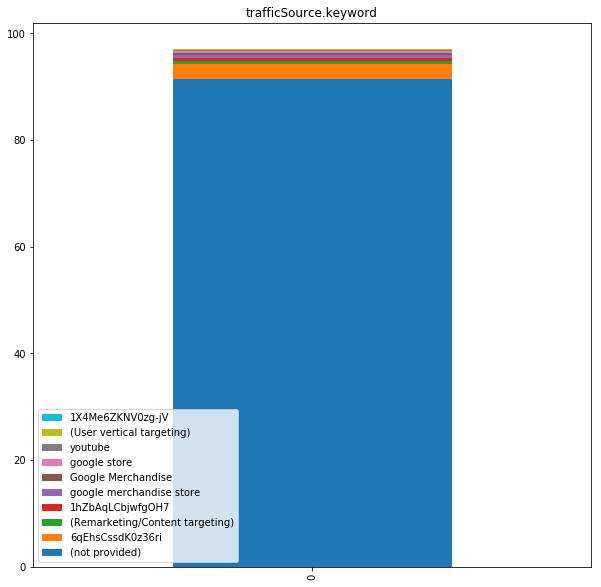

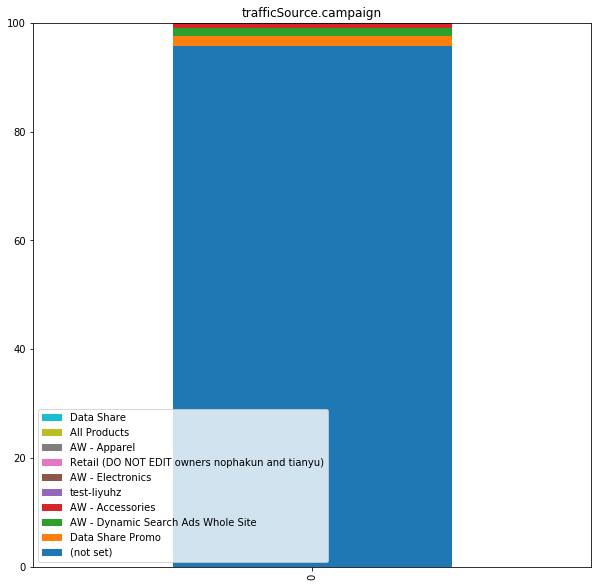

In [5]:
a= {}
for col in train.columns:
    if max(train[col].value_counts(normalize=True) * 100) > 5 and \
    max(train[col].value_counts(normalize=True)    * 100) < 99.99:
        a[col] = max(train[col].value_counts(normalize=True) * 100)
        
a = sorted(a.items(), key=lambda x: (x[1], x[0]))

dict = {col: (train[col].value_counts(normalize=True) * 100).head(10).to_dict() \
        for col in train.columns if (max((train[col].value_counts(normalize=True) * 100).head(10))> 5) \
        and max((train[col].value_counts(normalize=True) * 100).head(10) < 99.9)}

for i in a:
    #print(i[0], '\n', dict[i[0]],'\n')
    pd.DataFrame.from_dict(dict[i[0]], orient='index').T.plot.bar(title = i[0], legend = 'reverse', stacked=True)

**Посмотрим на график: клики (ось Y) и просмотры страниц (ось X)**

- Красными точками показаны сессии посещения интернет-магазина, при которых была совершена покупка.
- Чёрными точками отмечены сессии, при которых не было покупки.

(0, 150)

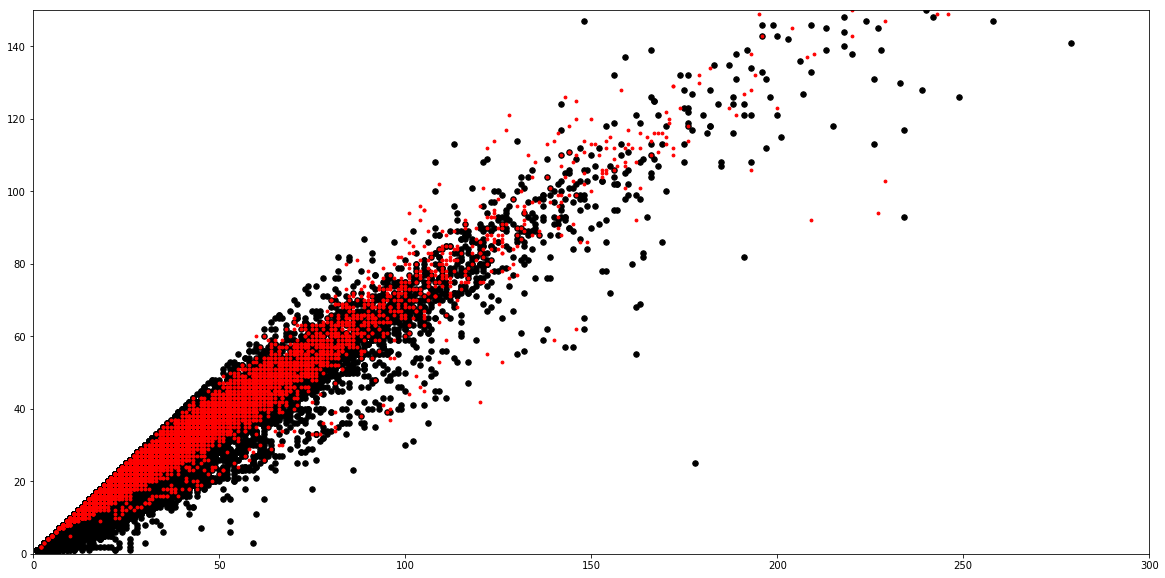

In [20]:
d1 = train.loc[train['totals.transactionRevenue'].isnull()][['totals.hits', 'totals.pageviews']]
d2 = train.loc[train['totals.transactionRevenue'] > 0][['totals.hits', 'totals.pageviews']]
plt.figure(figsize=(20,10))
plt.scatter(d1['totals.hits'], d1['totals.pageviews'], c='black',s=30)
 
plt.scatter(d2['totals.hits'], d2['totals.pageviews'], c='red',s=8)

plt.xlim(0,300)
plt.ylim(0,150)

**Посмотрим на агреггацию всех сессий пользователя**
- объединим клики и просмотры в одну сессию

In [31]:
df=train
list_new = []
counter_new = 0
df = df.sort_values('sessionId')
df = df.reset_index(drop=True)

for i in range(0, df.shape[0]):
    if i == 0:
        list_new.append(counter_new)
    elif df['visitStartTime'][i] - train['visitStartTime'][i-1] < 8640000000000:
        list_new.append(counter_new)
    else:
        counter_new += 1
        list_new.append(counter_new)

df['new'] = pd.Series(list_new)

columns = list(train.columns.values)
agg_columns = {
'totals.transactionRevenue': ['sum'],
'visitStartTime': ['mean'],
'totals.hits': ['sum'],
'totals.pageviews': ['sum']
}
aggregates = {}
for column in columns:
    if column in agg_columns:
        aggregates[column] = agg_columns[column]
    else:
        aggregates[column] = 'first'

df = df.groupby(['new', 'fullVisitorId']).agg(aggregates)
df.columns = df.columns.droplevel(1)
df = df.reset_index(drop=True)

(0, 150)

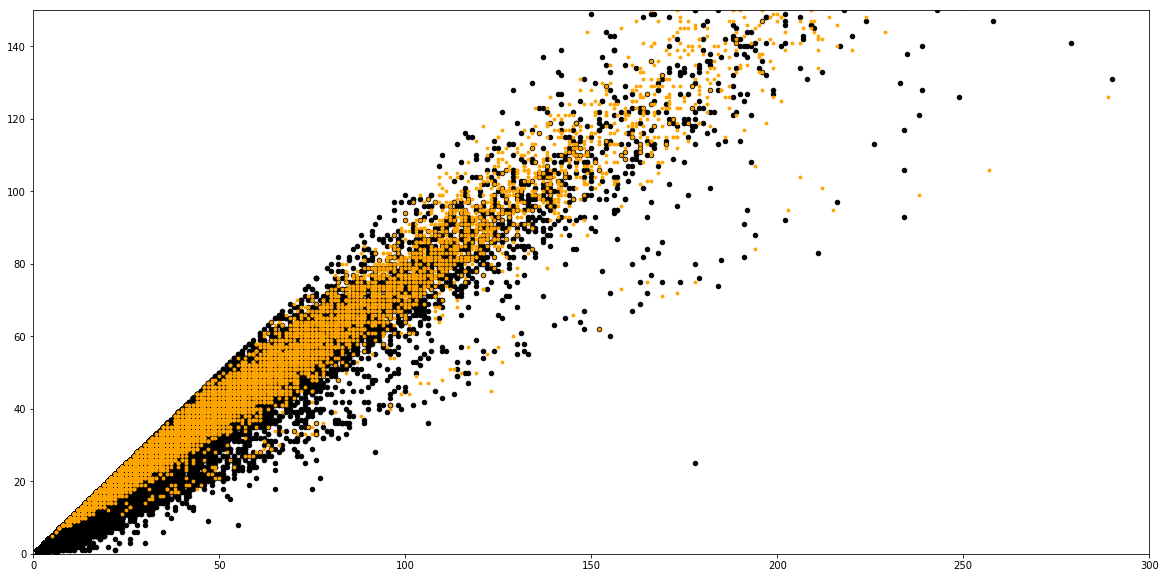

In [33]:
d3 = df.loc[df['totals.transactionRevenue'] < 1][['totals.hits', 'totals.pageviews']]
d4 = df.loc[df['totals.transactionRevenue'] > 0][['totals.hits', 'totals.pageviews']]
plt.figure(figsize=(20,10))
plt.scatter(d3['totals.hits'], d3['totals.pageviews'], c='black',s=20)
plt.scatter(d4['totals.hits'], d4['totals.pageviews'], c='orange',s=8)
plt.xlim(0,300)
plt.ylim(0,150)

**Добавим новые признаки - разность и отношение между hits и pageviews**

In [6]:
train['delta'] = train['totals.hits'] - train['totals.pageviews']
train['ratio'] = train['totals.hits']/train['totals.pageviews']

(0, 75)

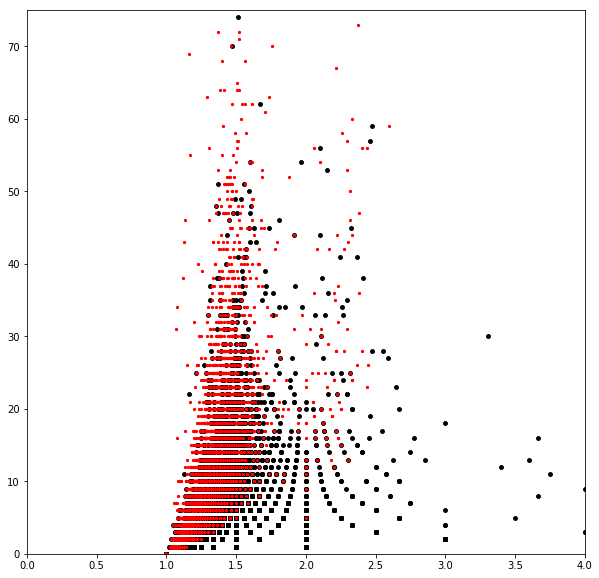

In [10]:
q1 = train.loc[train['totals.transactionRevenue'].isnull()][['delta','ratio']][:100000]
q2 = train.loc[train['totals.transactionRevenue'] > 0][['delta','ratio']][:100000]
plt.scatter(q1['ratio'], q1['delta'], c='black',s=15)
 
plt.scatter(q2['ratio'], q2['delta'], c='red',s=5)
plt.xlim(0,4)
plt.ylim(0,75)

**Посмотрим на распределение всех платежей по номеру посещения интернет-магазина**

In [11]:
top_revenue_by_visitNumber = train.loc[train['totals.transactionRevenue'] > 0].groupby('visitNumber')[['totals.transactionRevenue']].sum()/1000000
top_revenue_by_visitNumber.style.bar()

,totals.transactionRevenue
visitNumber,
1.0,382326
2.0,273156
3.0,194895
4.0,129921
5.0,96702.4
6.0,63259.8
7.0,49288.9
8.0,47334.1
9.0,29607.1


**Отобразим количество посещений по номеру визита**

In [12]:
top_by_visitNumber = train.loc[train['totals.transactionRevenue'].isnull()].groupby('visitNumber')[['visitNumber']].count()
top_by_visitNumber.style.bar(color=['#5fba7d'])

,visitNumber
visitNumber,
1.0,698595
2.0,90037
3.0,34412
4.0,18279
5.0,11060
6.0,7321
7.0,5167
8.0,3856
9.0,2935


**Посмотрим на временные графики**: все сессии, сессии с платежами, сессии без платежей

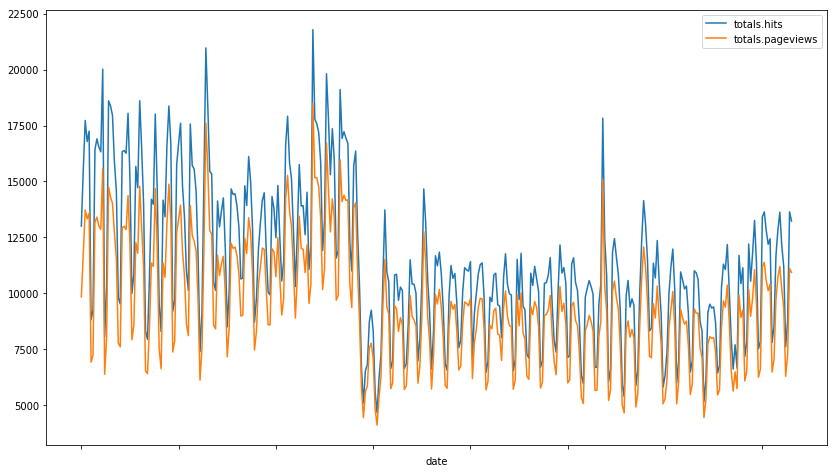

In [19]:
train2 = train.groupby('date')[['totals.hits','totals.pageviews']].sum()
rcParams['figure.figsize'] = 14, 8
train2.plot()

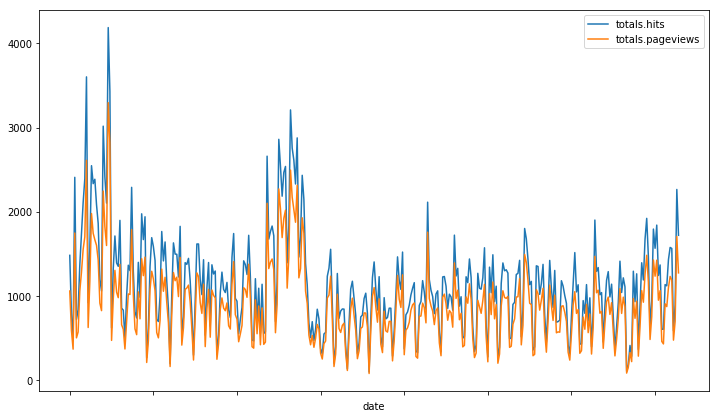

In [20]:
train3 = train.loc[train['totals.transactionRevenue']>0].groupby('date')[['totals.hits','totals.pageviews']].sum()
rcParams['figure.figsize'] = 12, 7
train3.plot()

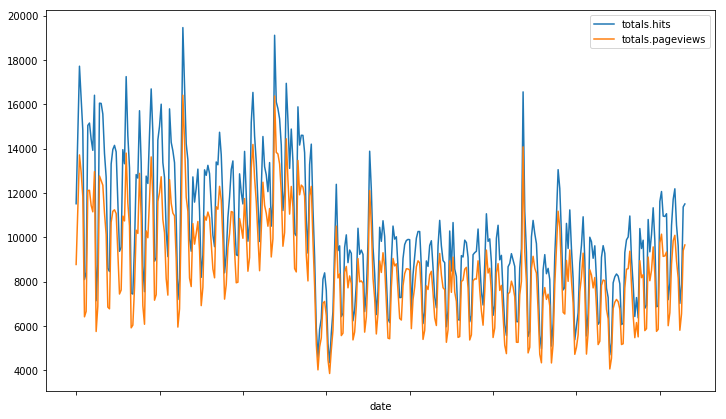

In [21]:
train3 = train.loc[train['totals.transactionRevenue'].isnull()].groupby('date')[['totals.hits','totals.pageviews']].sum()
rcParams['figure.figsize'] = 12, 7
train3.plot()